# Standard coalescent

In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [5]:
library(tidyverse)
library(devtools)
remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

Error : Could not copy `/Users/kmt/google_drive/projects/phasestype/PtDAlgorithms` to `/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T//Rtmp7ReS0h/filedc8969c04a22`


In [3]:
# remove.packages("ptdalgorithms")

In [57]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [10]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [11]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

# Issue: after expectation is run, gam$SIM doubles, fix or tell user not to reuse graph_as_matrix(graph) as matrix result

```
graph <- standard_coalescent(4)
print(graph_as_matrix(graph))
expectation(graph)
print(graph_as_matrix(graph))
```

## Generate standard coalescent state space

If you want to generate the state space:

In [12]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

## Standard coalescent from matrices

If you already have the subintensity matrix and initial probability vector:

In [13]:
sim = matrix(c(-6, 6, 0, 0, 
               0, -3, 1, 2,
               0, 0, -1, 0,
               0, 0, 0, -1), nrow=4, ncol=4, byrow = TRUE)
ipv = c(1, 0, 0, 0)
sim

[,1] [,2] [,3] [,4]
[1,] -6    6    0    0  
[2,]  0   -3    1    2  
[3,]  0    0   -1    0  
[4,]  0    0    0   -1

In [14]:
graph <- matrix_as_graph(ipv, sim)

**NB:** the state vectors are ofcause undefined (all zero) when constructing the graph this way:

In [15]:
gam <- graph_as_matrix(graph)
gam

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

In [16]:
dph(0.9, graph)

[1] 0.5362689

In [17]:
graph <- standard_coalescent(4)
gam <- graph_as_matrix(graph)
#vertices_length(graph)
gam

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

In [18]:
U <- -solve(gam$SIM)
U

[,1]      [,2]      [,3]      [,4]     
[1,] 0.1666667 0.3333333 0.3333333 0.6666667
[2,] 0.0000000 0.3333333 0.3333333 0.6666667
[3,] 0.0000000 0.0000000 1.0000000 0.0000000
[4,] 0.0000000 0.0000000 0.0000000 1.0000000

## Visualizing matrices and graphs

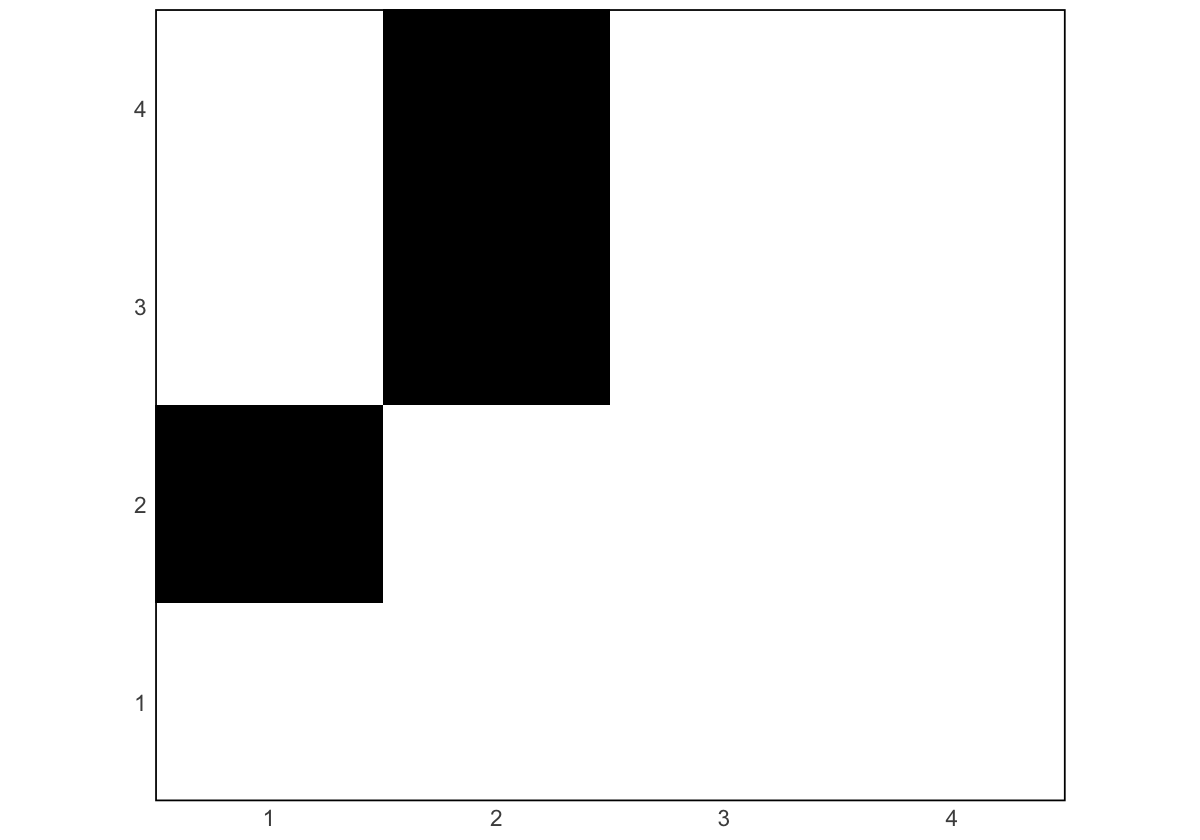

In [19]:
vertices <- vertices_length(graph)
plot_sim(graph) + theme(panel.border = element_rect(colour = "black", fill=NA,linewidth=1)) +
    scale_x_continuous(expand = c(0, 0), breaks = scales::breaks_pretty(5)) + 
    scale_y_continuous(expand = c(0, 0), breaks = scales::breaks_pretty(5)) + 
    theme(aspect.ratio=0.87)


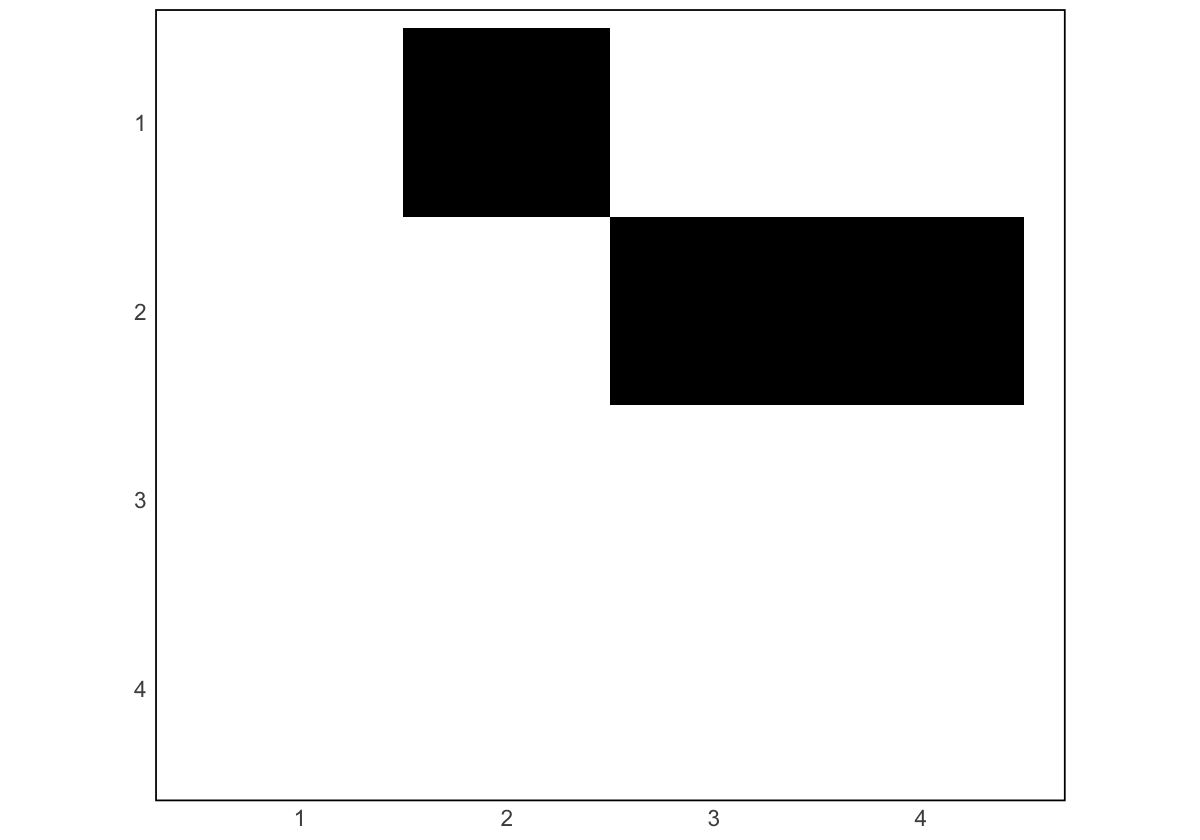

In [20]:
gam <- graph_as_matrix(graph)
mat <- gam$SIM
mat <- t(matrix(as.integer(mat > 0), dim(mat)))

rownames(mat) <- 1:nrow(mat)
colnames(mat) <- 1:ncol(mat)
df <- as.data.frame(mat)
df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
df$n <- as.numeric(df$n)
df$m <- as.numeric(df$m)
ggplot(df, aes(n, ordered(m, levels=rev(1:nrow(mat))))) +
    geom_tile(aes(fill = value), show.legend = FALSE) + 
    scale_fill_gradient(low="white", high="black") +
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(), 
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          text=element_text(size=17)) + theme(panel.border = element_rect(colour = "black", fill=NA,linewidth=1)) +
    # scale_x_continuous(expand = c(0, 0), breaks = scales::breaks_pretty(5)) + 
    # scale_y_continuous(expand = c(0, 0), breaks = scales::breaks_pretty(5)) + 
    theme(aspect.ratio=0.87)

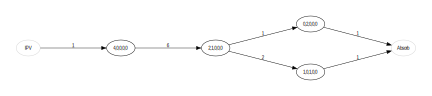

In [21]:
plot_graph(gam)

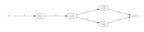

In [22]:
plot_graph(gam, size=c(2, 2))

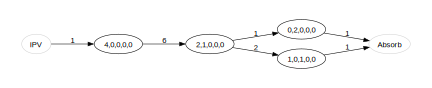

In [23]:
plot_graph(gam, fontsize=14, ranksep=1, nodesep=0.25)

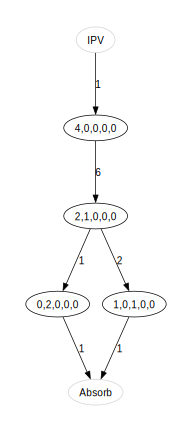

In [24]:
plot_graph(gam, rankdir="TB", fontsize=14, ranksep=1, nodesep=0.25)

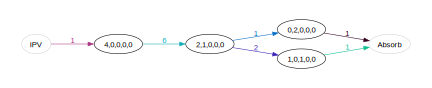

In [25]:
plot_graph(gam, fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

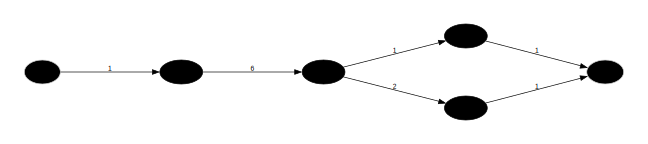

In [26]:
plot_graph(gam, size=c(9, 9), nodecolor='black')

## Convert to matrices

In [27]:
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

Invert subintensity matrix to get Green matrix:

In [28]:
U <- -solve(matrices$SIM)
U

[,1]      [,2]      [,3]      [,4]     
[1,] 0.1666667 0.3333333 0.3333333 0.6666667
[2,] 0.0000000 0.3333333 0.3333333 0.6666667
[3,] 0.0000000 0.0000000 1.0000000 0.0000000
[4,] 0.0000000 0.0000000 0.0000000 1.0000000

Compute expectation from matrices:

In [29]:
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

[,1]
[1,] 1.5

## Compute moments

Expectation:

In [30]:
expectation(graph)

[1] 1.5

In [31]:
expected_waiting_time(graph)

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000

Variance:

In [32]:
variance(graph)

[1] 1.138889

In [33]:
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 1.138889 1.138889 1.111111 1.000000 1.000000 0.000000

or computed from the second moment:

In [34]:
exp_wait_1nd_moment = expected_waiting_time(graph)
exp_wait_1nd_moment

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000

In [35]:
exp_wait_2nd_moment = expected_waiting_time(graph, exp_wait_1nd_moment)
exp_wait_2nd_moment

[1] 1.694444 1.694444 1.444444 1.000000 1.000000 0.000000

In [36]:
(2 * exp_wait_2nd_moment - exp_wait_1nd_moment**2)[1]

[1] 1.138889

In [37]:
(2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph))[1]

[1] 1.138889

Four moments:

In [38]:
moments(graph, 4)

[1]  1.500000  3.388889 10.583333 42.907407

Marginal expectations using rewards:

In [39]:
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

[,1] [,2] [,3] [,4] [,5] [,6]
[1,] 0    4    2    0    1    0   
[2,] 0    0    1    2    0    0   
[3,] 0    0    0    0    1    0   
[4,] 0    0    0    0    0    1   
[5,] 0    0    0    0    0    0

Rows happens to be our reward vectors. E.g. singleton rewards:

In [40]:
states(graph)

[,1] [,2] [,3] [,4] [,5]
[1,] 0    0    0    0    0   
[2,] 4    0    0    0    0   
[3,] 2    1    0    0    0   
[4,] 0    2    0    0    0   
[5,] 1    0    1    0    0   
[6,] 0    0    0    1    0

In [44]:
rewards <- states(graph)
singletons <- rewards[,1]
doubletons <- rewards[,2]
tripletons <- rewards[,3]
singletons

[1] 0 4 2 0 1 0

In [45]:
# rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
# singletons <- rewards[1,]
# doubletons <- rewards[2,]
# tripletons <- rewards[3,]
# singletons

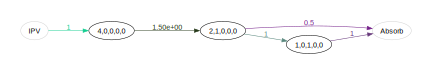

In [46]:
new_graph <- reward_transform(graph, singletons)
plot_graph(graph_as_matrix(new_graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

In [51]:
state <- vertex_at(graph, 2)$state
state

[1] 4 0 0 0 0

In [52]:
find_vertex(new_graph, state)

NULL

In [53]:
states(new_graph)

[,1] [,2] [,3] [,4] [,5]
[1,] 0    0    0    0    0   
[2,] 4    0    0    0    0   
[3,] 2    1    0    0    0   
[4,] 1    0    1    0    0   
[5,] 0    0    0    1    0

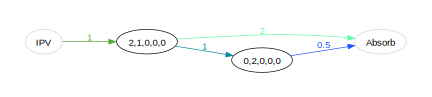

In [135]:
new_graph <- reward_transform(graph, doubletons)
plot_graph(graph_as_matrix(new_graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

In [136]:
vertex_at(new_graph, 3)

$state
[1] 0 2 0 0 0

$rate
[1] 0.5

$index
[1] 3

$vertex
[1] 1.055532e+14

$xptr_vertex
<pointer: 0x6000023f0070>


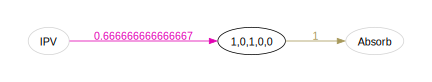

In [137]:
new_graph <- reward_transform(graph, tripletons)
plot_graph(graph_as_matrix(new_graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

In [139]:
for (v in vertices(new_graph)) { print(v) }

$state
[1] 0 0 0 0 0

$rate
[1] 1

$index
[1] 1

$vertex
[1] 1.055532e+14

$xptr_vertex
<pointer: 0x6000023dc350>

$state
[1] 1 0 1 0 0

$rate
[1] 1

$index
[1] 2

$vertex
[1] 1.055532e+14

$xptr_vertex
<pointer: 0x6000023dc5c0>

$state
[1] 0 0 0 1 0

$rate
[1] 0

$index
[1] 3

$vertex
[1] 1.055532e+14

$xptr_vertex
<pointer: 0x6000023dc220>



In [47]:
plot_graph(graph_as_matrix(reward_transform(graph, singletons)), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

ERROR: Error in eval(expr, envir, enclos): Failed: Rewards must match the number of vertices. Expected 3, got 6


Expected tripleton branch length:

In [41]:
expectation(graph, tripletons)

[1] 0.6666667

## SFS

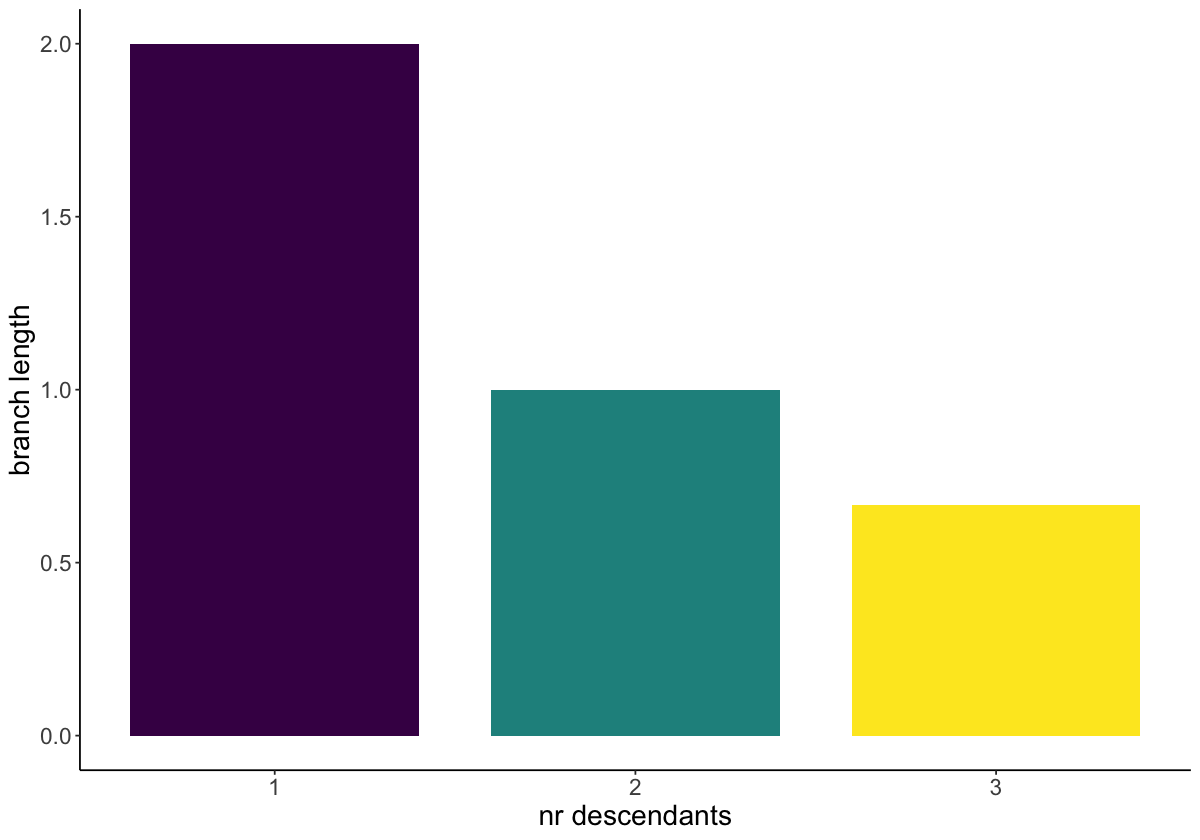

In [42]:
plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") +  scale_x_continuous(breaks = 1:9)+ theme(legend.position = "none") + labs(x='nr descendants')
ggsave('~/Desktop/sfs.pdf', width=6, height=4) 

## Covariance

In [43]:
covariance(graph, singletons, doubletons)

[1] -0.2222222

Covariane between "ton" branch length:

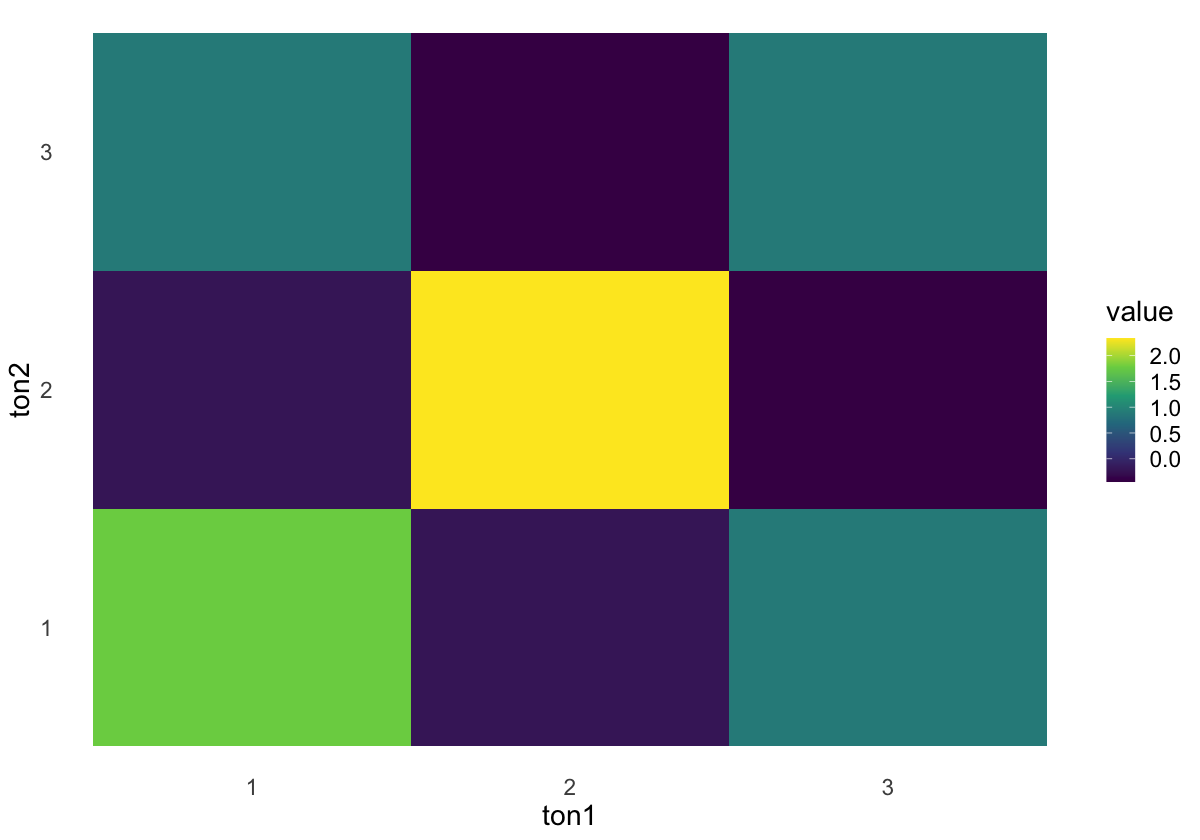

In [44]:
plot_cov_mat(get_cov_mat(graph, rewards))

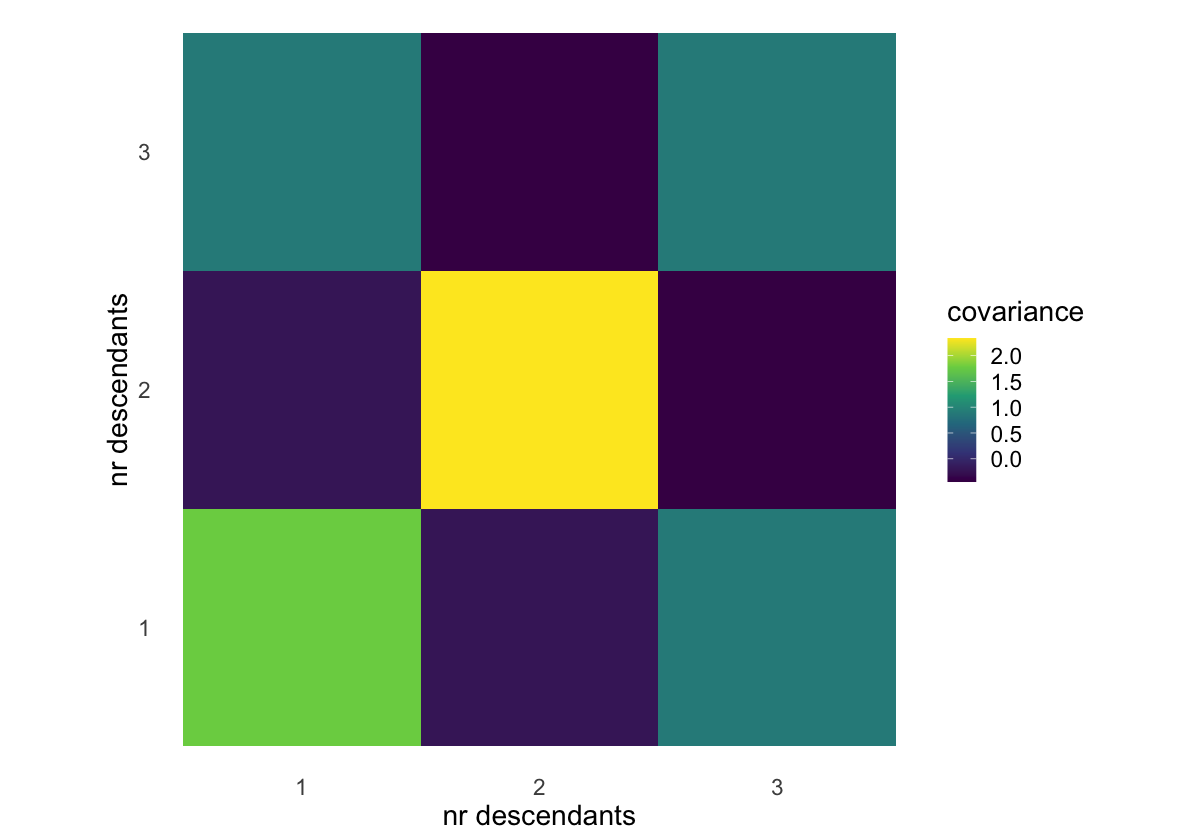

In [45]:
plot_cov_mat(get_cov_mat(graph, rewards)) + theme(aspect=1) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')
ggsave('~/Desktop/sfs_cov.pdf', width=6, height=4)

Distributions of each "ton" branch length:

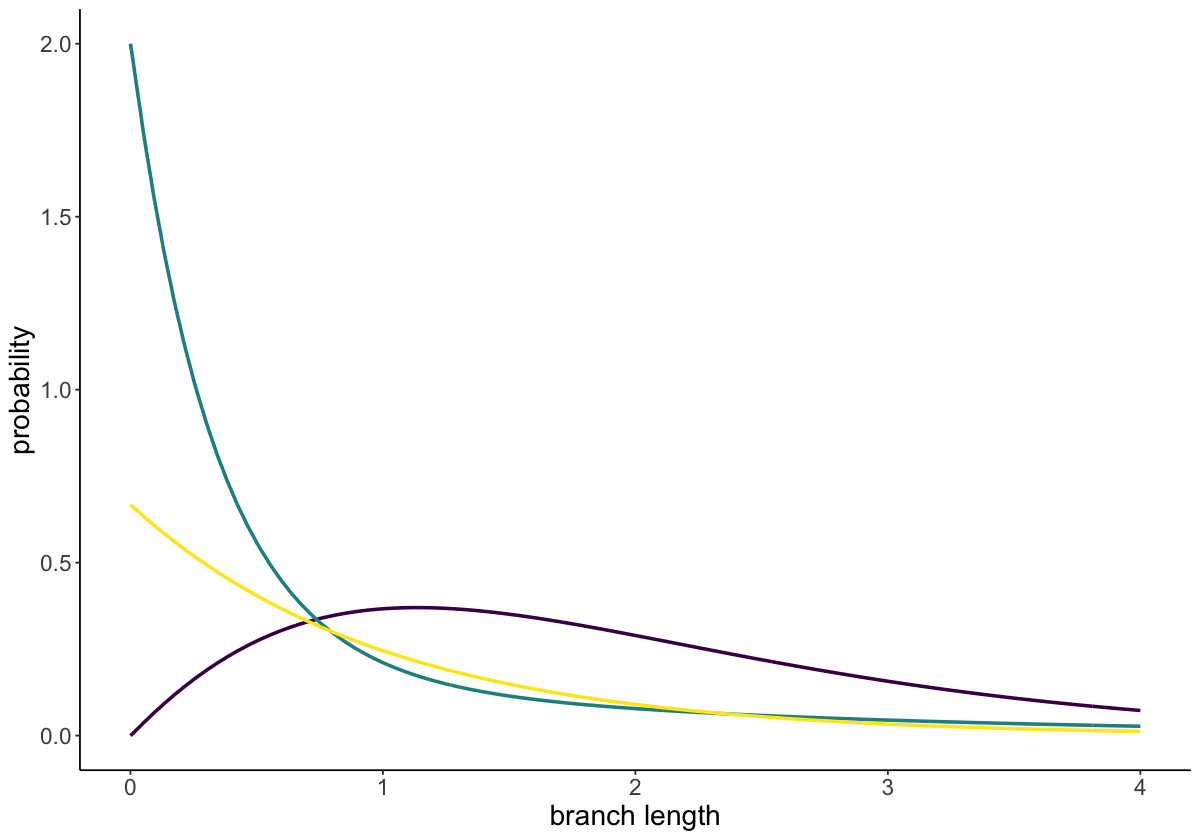

In [46]:
source("plot_functions.R")
plot_sfs_dph(graph, rewards) + theme(legend.position = "none") + labs(x = "branch length")
ggsave('~/Desktop/sfs_dph.pdf', width=6, height=4)

Compute expectations from the distributions:

In [47]:
ctx <- distribution_context(graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))

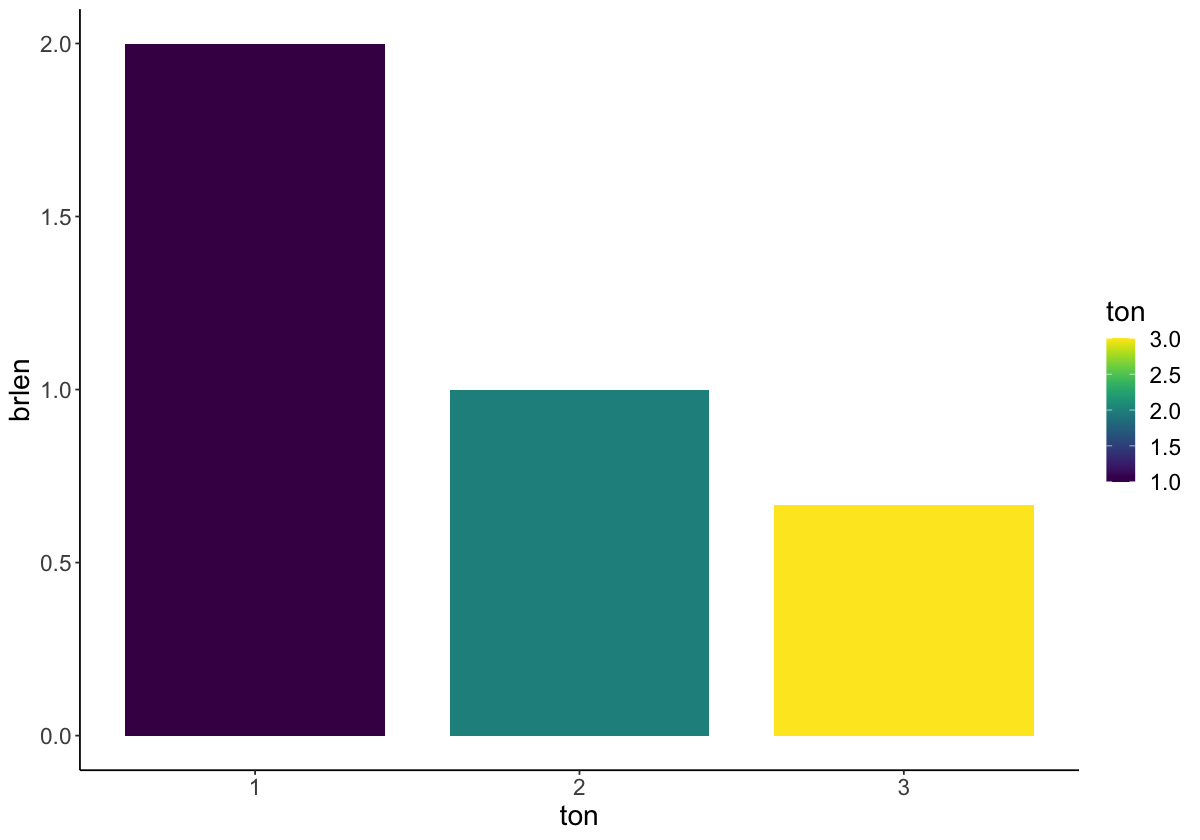

In [48]:
data.frame(ton=seq(1,length(sfs)), brlen=sfs) %>%
ggplot(aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + despine

Changing rates (edge weights) using parametrization:

In [49]:
graph_update_weights_parameterized(graph, c(2))

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM
gam <- graph_as_matrix(graph)

Change rates back to normal:

In [50]:
graph_update_weights_parameterized(graph, c(1))

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

## Distribution over states at accross time

In [51]:
t <- seq(from = 0, to = 5, by = 0.01)
fun <- function(t) {
    x <- stop_probability(graph, t)
    return(x[2:(length(x)-1)])
}
df <- as.data.frame(t(sapply(t, fun))) 
df['time'] <- t
head(df)

V1        V2         V3           V4           time
1 1.0000000 0.00000000 0.0000000000 0.0000000000 0.00
2 0.9374023 0.06167808 0.0003056227 0.0006112454 0.01
3 0.8839023 0.11268746 0.0011296433 0.0022592865 0.02
4 0.8334556 0.15920896 0.0024216864 0.0048433728 0.03
5 0.7858880 0.20154429 0.0041349045 0.0082698089 0.04
6 0.7366933 0.24361558 0.0064540291 0.0129080582 0.05

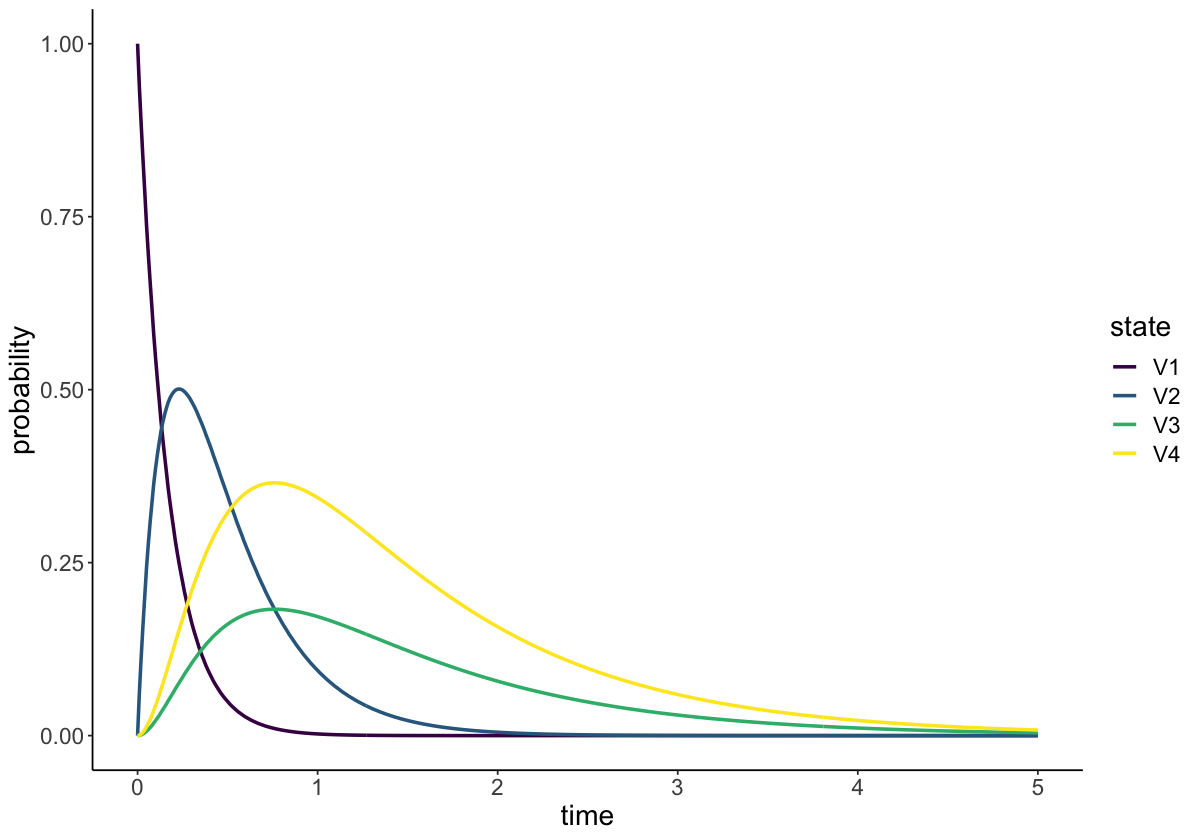

In [52]:
df %>% gather(state, probability, -time) %>% ggplot(aes(y=probability, x=time, group=state, color=state)) +
        geom_line(linewidth=1) + scale_color_viridis(discrete=TRUE) + despine

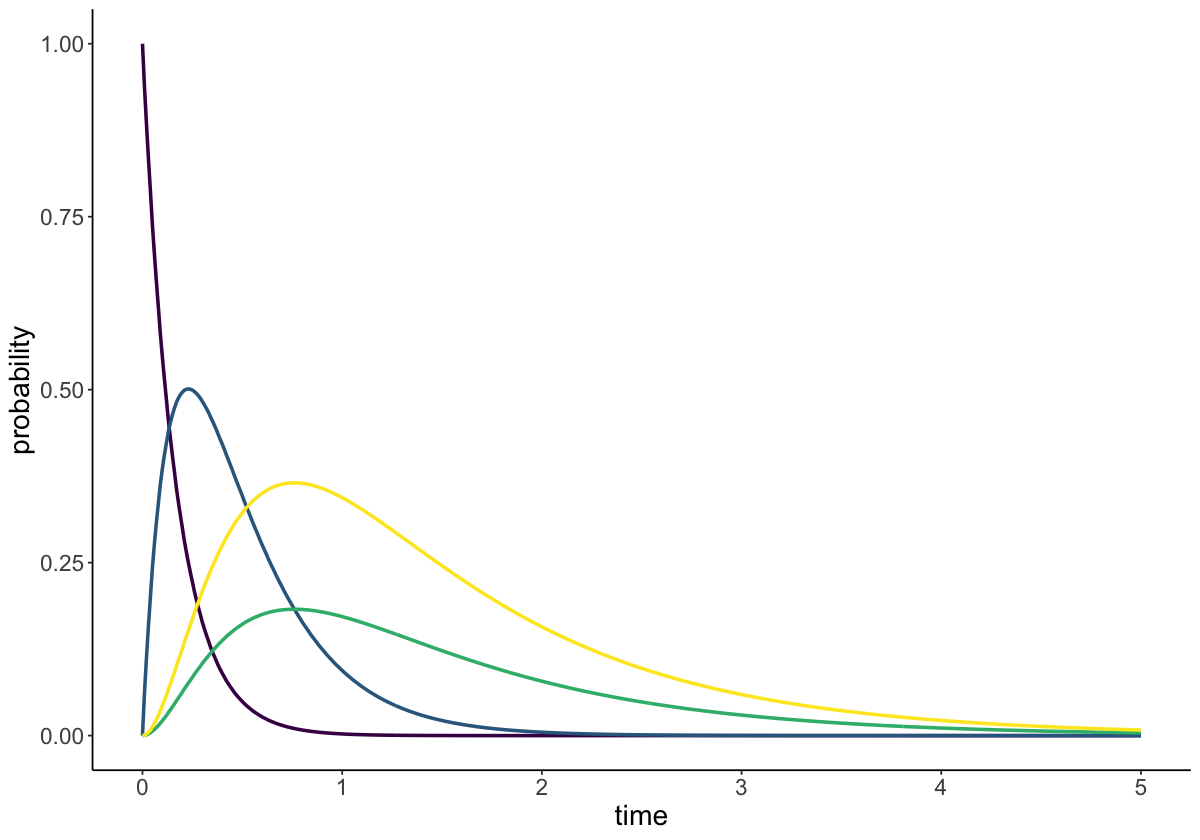

In [53]:
df %>% gather(state, probability, -time) %>% ggplot(aes(y=probability, x=time, group=state, color=state)) +
        geom_line(linewidth=1) + scale_color_viridis(discrete=TRUE) + despine + theme(legend.position = "none")

**Convolution howto:**

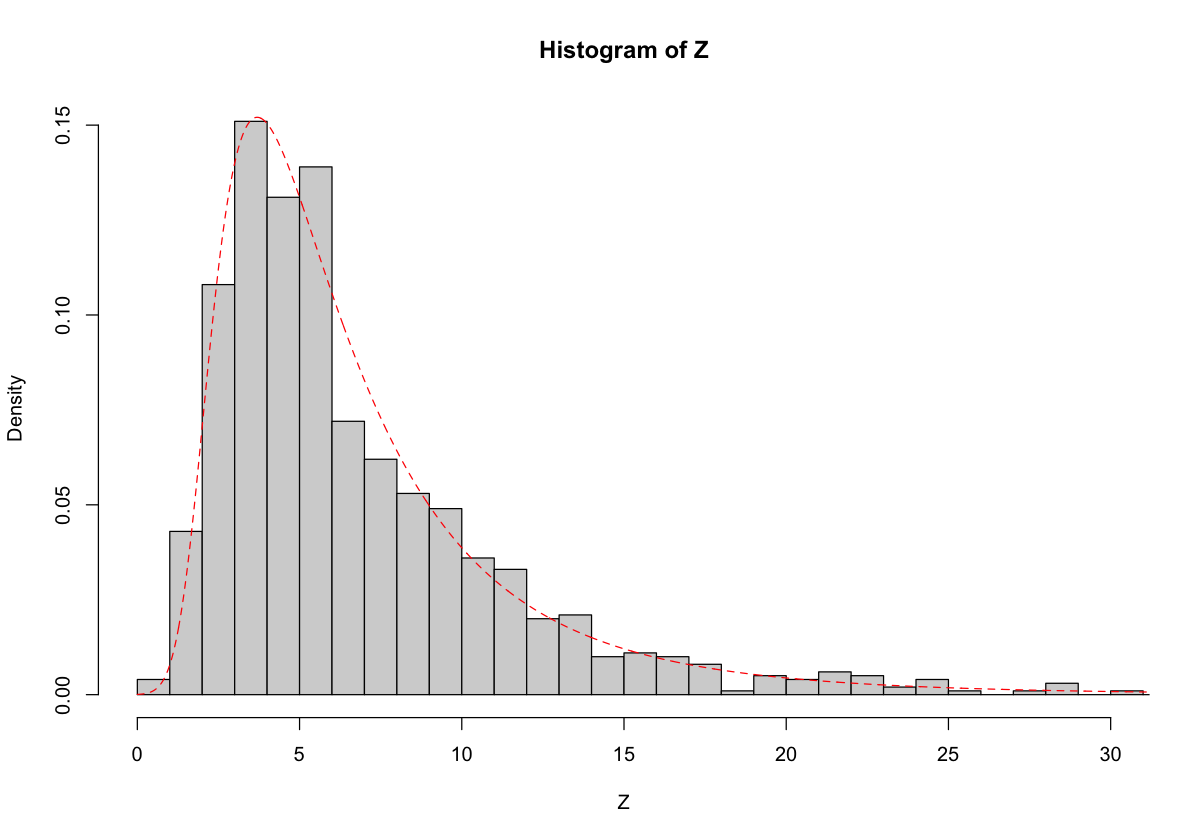

In [54]:
f.X <- function(x) dnorm(x,1,0.5)        # normal (mu=1.5, sigma=0.5)
f.Y <- function(y) dlnorm(y,1.5, 0.75)   # log-normal (mu=1.5, sigma=0.75)
# convolution integral
integrand <- function(x, z) f.Y(z-x)*f.X(x)
f.Z <- function(z) integrate(integrand,-Inf,Inf,z)$value
f.Z <- Vectorize(f.Z) 
                             
set.seed(1)                              # for reproducible example
X <- rnorm(1000,1,0.5)
Y <- rlnorm(1000,1.5,0.75)
Z <- X + Y
# compare the methods
hist(Z,freq=F,breaks=50, xlim=c(0,30))
z <- seq(0,50,0.01)
lines(z,f.Z(z),lty=2,col="red")                    

## Time-inhomgeneous coalescent

The distribution context is always made on the graph without rewards transformation. You can then:

- Get the distribution (and from that all moments) of time to absorbtion. Note that you cannot use dph for this as this assumes the current edge-weights and not seqentially updated ones in the distribution context.
- Get the marginal expectations by summing over the products of the expected accumulated visiting times and rewards.


In [55]:
cdf_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$cdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)        
    }

    return(data.frame(prob = unlist(tmrca_pdf), t=unlist(time)))

}

epoques = c(0, 1, 2, 3, 4)
cdf1 <- cdf_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
cdf2 <- cdf_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
cdf3 <- cdf_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

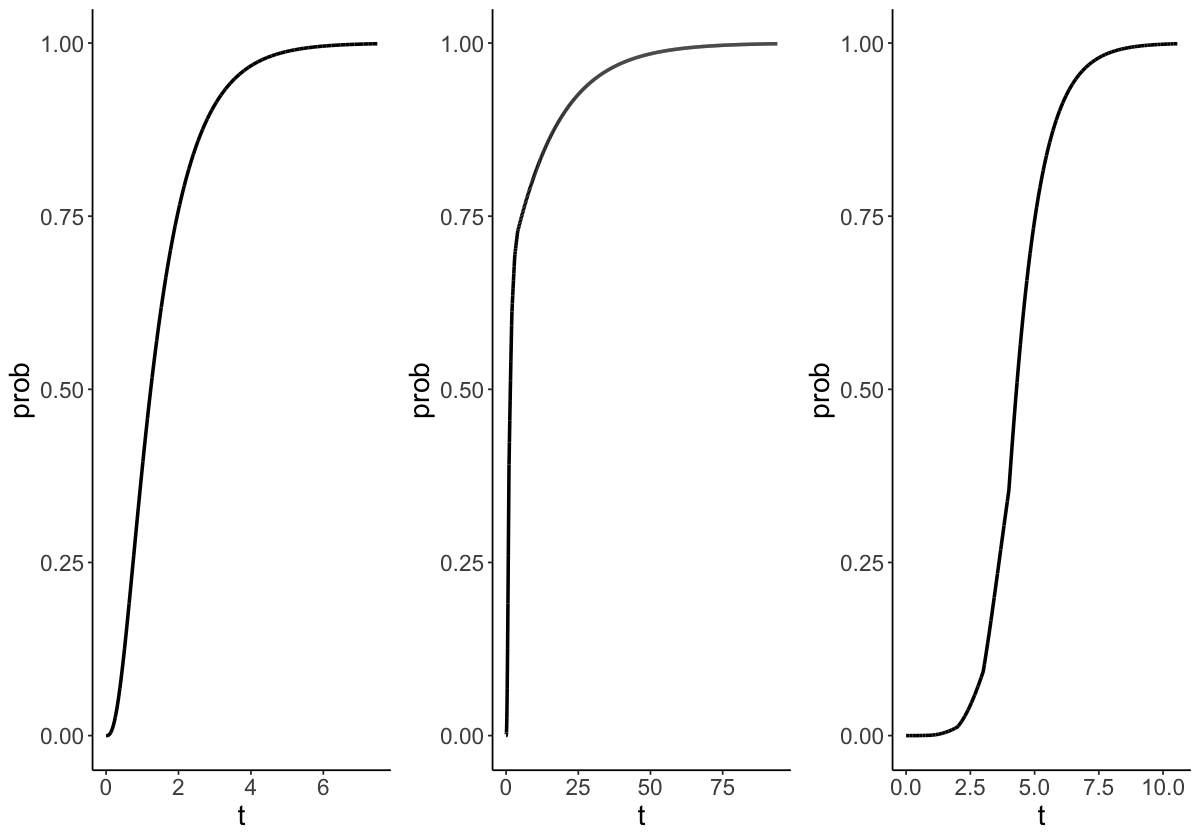

In [56]:
grid.arrange(
    ggplot(cdf1, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
    ggplot(cdf2, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
    ggplot(cdf3, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
 nrow = 1) 

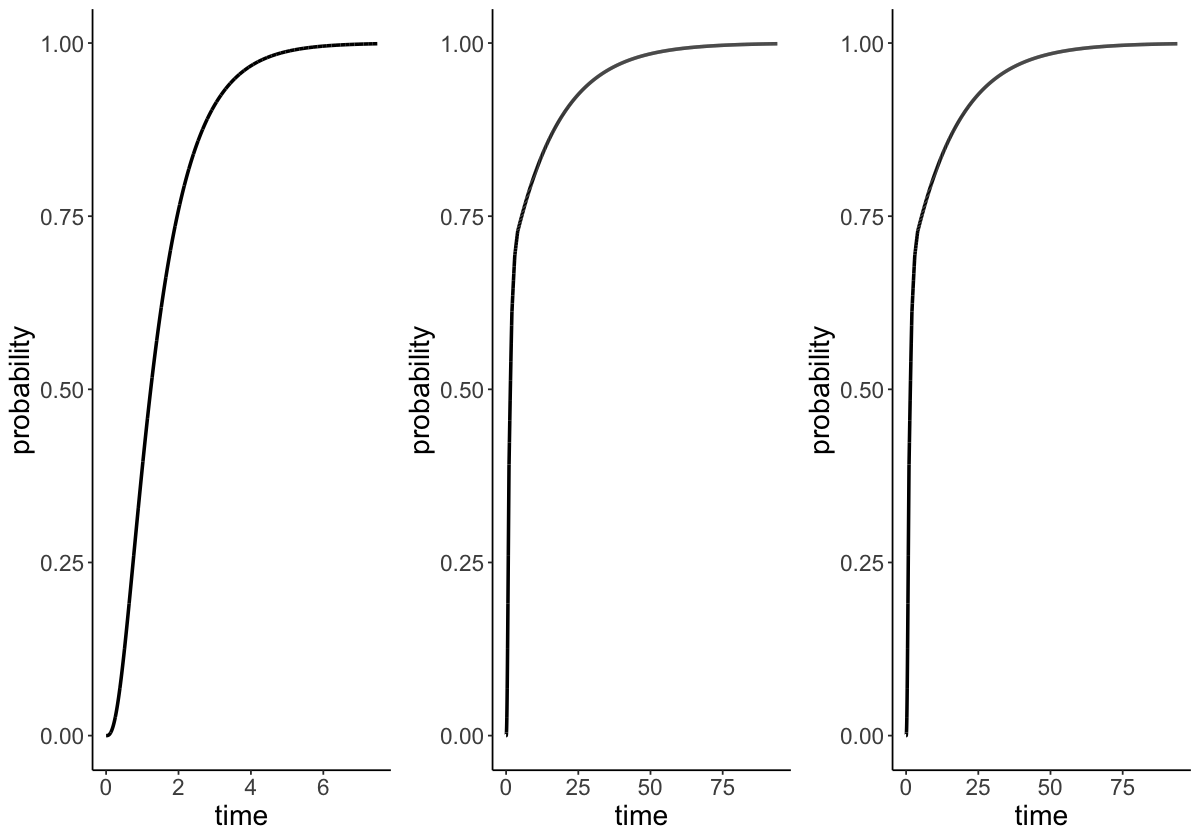

In [57]:
library('grid')
g1 <- ggplot(cdf1, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(y='probability', x='time')
g2 <- ggplot(cdf2, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(y='probability', x='time')
g3 <- ggplot(cdf3, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(y='probability', x='time')
grid.newpage()
grid.draw(cbind(ggplotGrob(g1), ggplotGrob(g2), ggplotGrob(g2), size = "last"))

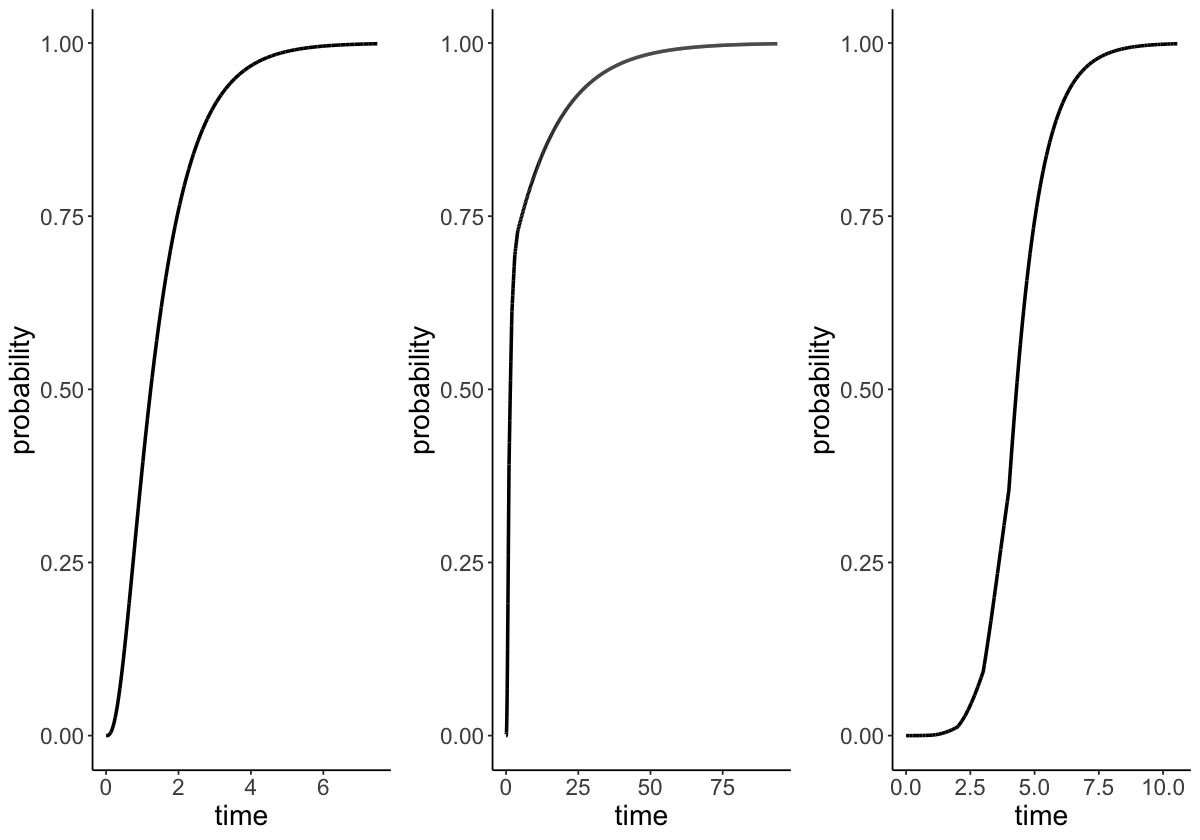

In [58]:
p<- grid.arrange(
    ggplot(cdf1, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(x = "time", y='probability'),
    ggplot(cdf2, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(x = "time", y='probability'),
    ggplot(cdf3, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine + labs(x = "time", y='probability'),
 nrow = 1) 
grid.draw(p) # interactive device
ggsave("~/Desktop/timeinhom-cdf.pdf", p,  width=10, height=3)

In [100]:
sfs_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        # tmrca_pdf <- c(tmrca_pdf, distribution_context_state(ctx)$pdf)
        # time <- c(time, distribution_context_state(ctx)$time)
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }
    expected_visits <- distribution_context_accumulated_visiting_time(ctx)
    sfs <- c()
    for (i in 1:(dim(rewards)[1]-1)) {
        sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
    }
    return(sfs)
}

epoques = c(0, 1, 2, 3, 4)
sfs1 <- sfs_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
sfs2 <- sfs_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
sfs3 <- sfs_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))
# Bug fix!: this 
# sfs3 <- sfs_timeinhom(graph, epoques, c(1, 1/2, 1/4, 1/8, 1/16))
#produces same sfs as constant size

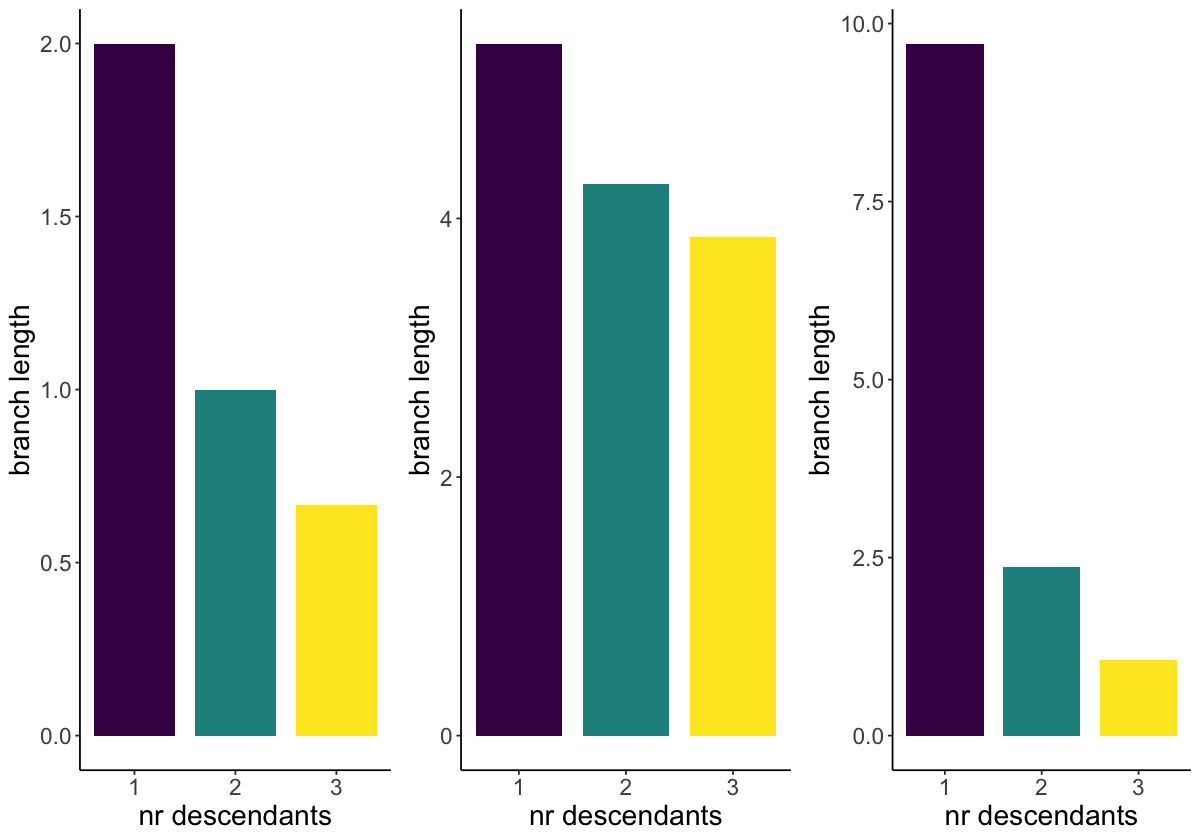

In [60]:
p <- grid.arrange(
    data.frame(
      ton=seq(1,length(sfs1)),  
      brlen=sfs1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none") +
            labs(y = "branch length", x='nr descendants'),
    data.frame(
      ton=seq(1,length(sfs2)),  
      brlen=sfs2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none") +
            labs(y = "branch length", x='nr descendants'),
    data.frame(
      ton=seq(1,length(sfs3)),  
      brlen=sfs3
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none") +
            labs(y = "branch length", x='nr descendants'), 
    nrow = 1)
grid.draw(p) # interactive device
ggsave("~/Desktop/timeinhom-sfs.pdf", p,  width=10, height=3)

# Test

In [61]:
epoques = c(0)
sfs_timeinhom(graph, epoques, c(1))

[1] 1.9993341 0.9993341 0.6660008

In [62]:
epoques = c(0, 1)
sfs_timeinhom(graph, epoques, c(1, 1))

[1] 1.9993341 0.9993341 0.6660008

# Discrete phase-type distribution

First build representation of the continuous phase-type distribution for the coalescent:

In [101]:
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate
        )
    }
  }
      
  index <- index + 1
}

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 628

In [102]:
plot_graph(gam)

Then turn it into a descrete phase-type distribution:

In [103]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# self-transition rate:
mutation_rate <- 1e-8

# clone graph to get one to modify:
mutation_graph <- clone_graph(graph)

# add auxilliary states, normalize and return reward matrix:
rewards <- make_discrete(mutation_graph, mutation_rate)

# for plotting the new graph
gam <- graph_as_matrix(mutation_graph)

In [ ]:
plot_graph(gam)

In [ ]:
plot_sfs(mutation_graph, rewards)

Covariance:

In [ ]:
covariance(mutation_graph, rewards[1,], rewards[2,])

In [ ]:
covariance(mutation_graph, rewards[1,], rewards[3,])

Covariane between "ton" branch length:

In [ ]:
plot_cov_mat(get_cov_mat(mutation_graph, rewards))

In the discrete version, the covariances between tons are the same, but the variance with the same ton between loci (diagonal) is different. The ton variance is much bigger in the discrete version, and the between-locus same-ton variance is almost the same as the ton variance.

Distributions of each "ton":

Notice the difference to the branch length variance above. E.g. in the continuous case the was zero prob of zero singleton branch length, here there no longer zero prob of a no singletons:

In [ ]:
source("plot_functions.R")
plot_sfs_dph(mutation_graph, rewards, trunc=10)

Compute expectations from the distributions:

In [ ]:
ctx <- distribution_context(mutation_graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))
sfs

In [ ]:
data.frame(
  ton=seq(1,length(sfs)),  
  brlen=sfs
  ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
        geom_bar(stat = "identity", width=0.8) + 
        scale_fill_viridis() + 
        despine + 
        theme(legend.position = "none")

## Expectation vs. variance

In [44]:
means <- c()
stds <- c()
sampled_individuals <- seq(2, 40)
for (n in sampled_individuals)
{
    graph <- standard_coalescent(n)
    means <- c(means, expectation(graph))
    stds <- c(stds, sqrt(variance(graph)))
}

In [45]:
library(reshape2)


Vedhæfter pakke: ‘reshape2’


Det følgende objekt er maskeret fra ‘package:tidyr’:

    smiths




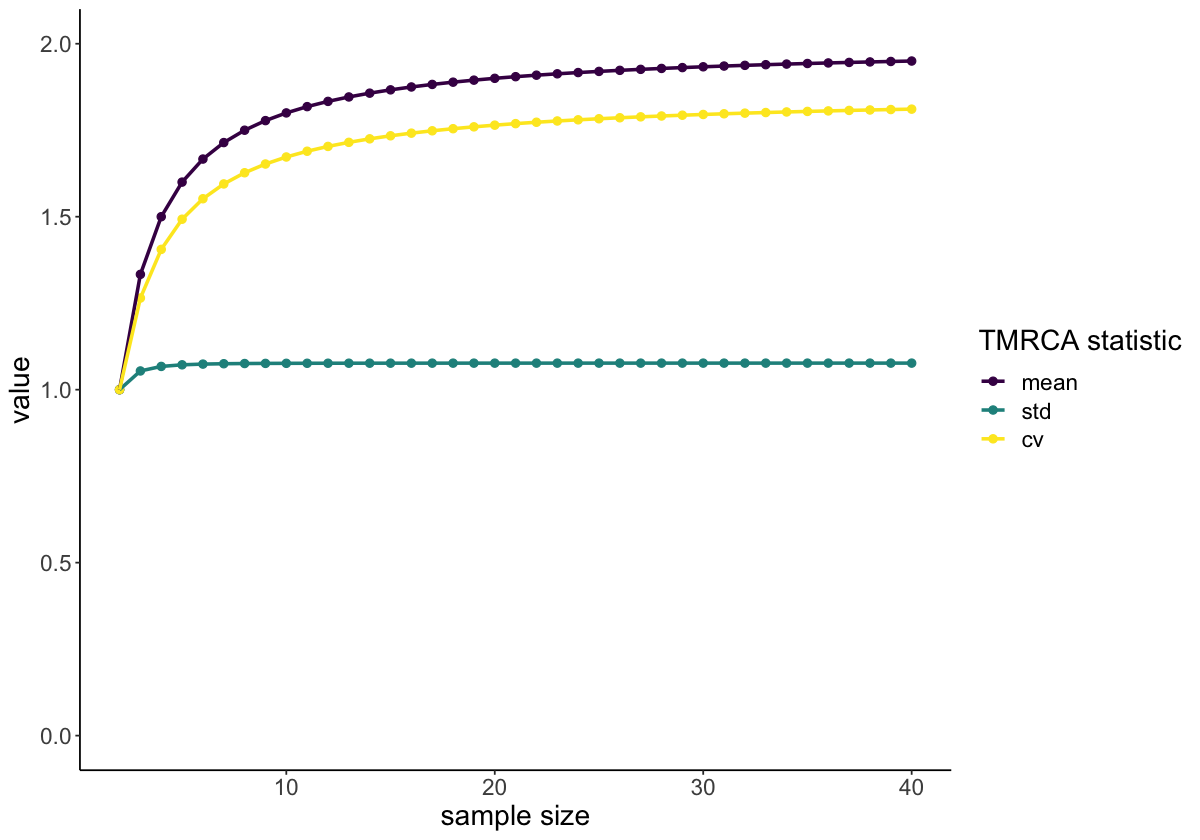

In [46]:
df <- data.frame(mean=means, std=stds, cv=means/stds, sample_size=sampled_individuals)
df <- melt(df, id.vars = c("sample_size"))

ggplot(data=df, aes(x=sample_size, y=value, group=variable, color=variable)) + geom_point(size=2) + geom_line(linewidth=1) + ylim(0, 2) + labs(x='sample size', y='value', color='TMRCA statistic') + despine + scale_color_viridis(discrete = TRUE)
ggsave('~/Desktop/tmrca_by_samplesize.pdf', width=7, height=5)

In [47]:
df <- data.frame(t=seq(1, 6, 0.001))
for (n in seq(2, 20))
{
    graph <- standard_coalescent(n)
    df[[n]] <- sapply(df$t, function (t) dph(t, graph))
}

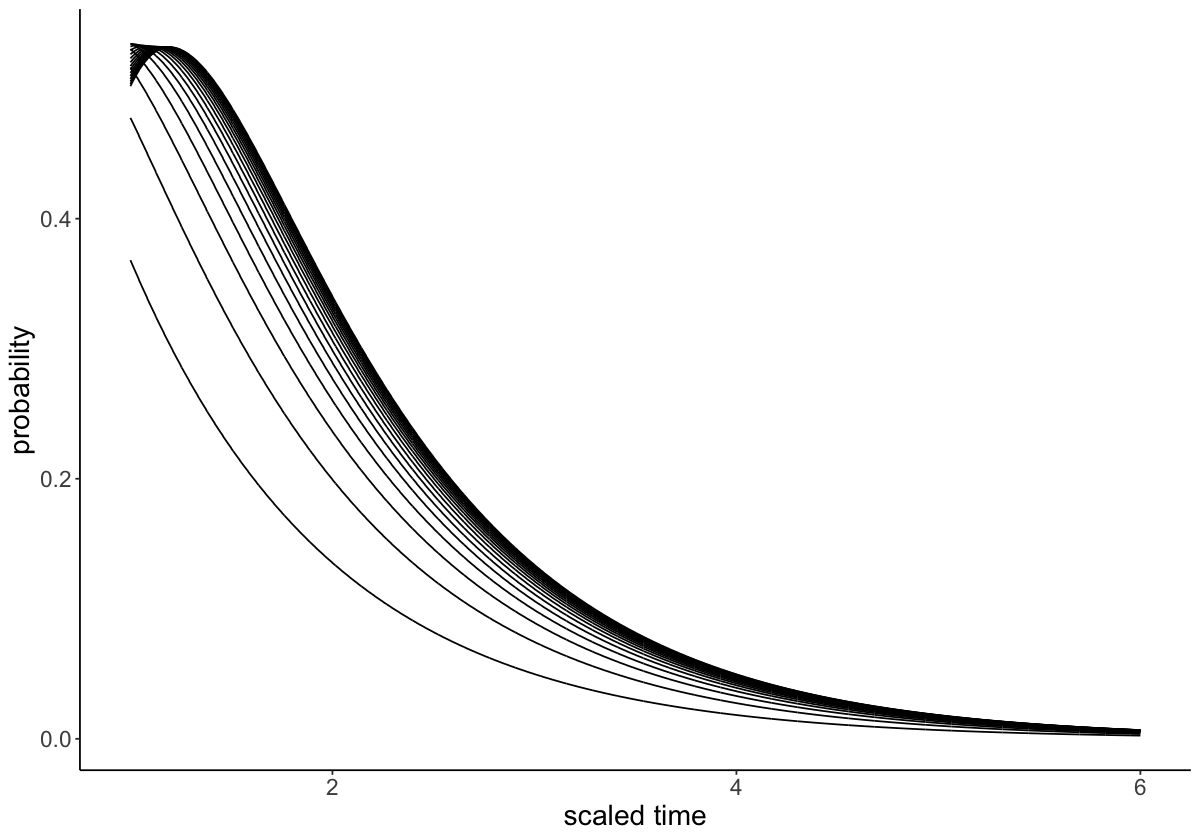

In [48]:
df %>% pivot_longer(!t, names_to="sample_size", values_to='prob') %>% ggplot(aes(x=t, y=prob, group=sample_size, color=sample_size)) + geom_line(color='black') + labs(x='scaled time', y='probability', color='sample size') + despine + scale_color_viridis(discrete = TRUE)

ggsave('~/Desktop/tmrca_pdf_by_samplesize.pdf', width=7, height=5)